<h1>Computing expansion of the loss function up to order 4</h1>

We refer to https://www.e-publications.org/ims/submission/BEJ/user/submissionFile/49843?confirm=55a2fac1.
In this notebook, we show how we can compute the higher order nested expansion of some objective function to be minimized. In some real-life problems, the Hessian matrix can be singular at the minimum so we need to investigate higher order derivative tensors.

<h3>Imports</h3>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

<h3>Data and model</h3>

In [14]:
(features, labels), _ = tf.keras.datasets.mnist.load_data()
features = features / 255.0
features = features.reshape((features.shape[0],28,28,1))

model = tf.keras.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(10)
])

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

<h3>Fit the model</h3>
and get x_star which is the minimizer of the loss.

In [15]:
model.fit(features, labels, batch_size=32, epochs=30, verbose=0)
x_star = [[weight for weight in layer.weights] for layer in model.layers]

<h3>Compute the Hessian matrix of the loss</h3>
We compute the Hessian matrix of the loss with respect to the kernel of the second Dense layer, as we cannot compute the whole Hessian matrix with respect to all the variables.

We use np.linalg.eig giving the eigenvalues and the eigenvectors of the Hessian matrix. We need to use tf.GradientTape.jacobian instead of tf.GradientTape.gradient since the later can only compute the gradient of a scalar (and not the jacobian of a tensor).

We then select two direction vectors belonging to the kernel of the second Dense layer ; we will then compute the gradient and higher derivative tensors (up to the order four) w.r.t. to these two vectors only.

In [35]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss(model, x, y):
  y_ = model(x)
  return loss_object(y_true=y, y_pred=y_)

# we compute the Hessian matrix with respect to the kernel matrix of the second Dense layer
def T2_compute(model, inputs, targets, nb):
    with tf.GradientTape() as g1:
        with tf.GradientTape() as g2:
            loss_value = loss(model, inputs, targets)
        grads = g2.gradient(loss_value, model.trainable_variables[nb])
    hess_matrix = g1.jacobian(grads, model.trainable_variables[nb])
    return hess_matrix

hessian = T2_compute(model, features, labels, -4)
hessian = tf.reshape(hessian, [hessian.shape[0]*hessian.shape[1],hessian.shape[0]*hessian.shape[1]])
hessian_np = np.array(hessian)
w, v = np.linalg.eig(hessian_np)
w, v = np.real(w), np.real(v)
# we take the real part as some eigenvalues may be complex due to numerical error

In [36]:
# we choose two direction eigenvectors, one with non-zero eigenvalue and the other one with zero eigenvalue.
index = np.argmax(w<1e-6)
direction_vectors = tf.stack([v[:,index-1], v[:,index+1]])
nb_directions = direction_vectors.shape[0]

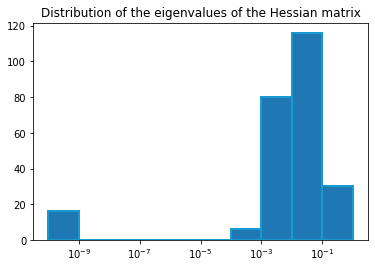

[3.15813255e+00 2.25391889e+00 2.15384388e+00 1.99351418e+00
 1.69402933e+00 1.57552505e+00 1.27419889e+00 1.07338202e+00
 6.40094340e-01 5.06736159e-01 4.86038148e-01 4.18705821e-01
 3.79946589e-01 3.09994966e-01 2.91308343e-01 2.52507776e-01
 2.43038386e-01 2.30396152e-01 2.28465006e-01 2.01890990e-01
 1.93474591e-01 1.89883307e-01 1.72230050e-01 1.65611193e-01
 1.60776019e-01 1.53749824e-01 1.53215364e-01 1.46760583e-01
 1.44898981e-01 1.38880402e-01 1.24889910e-01 1.22316323e-01
 1.20219991e-01 1.15891546e-01 1.12791896e-01 1.06174216e-01
 1.02588274e-01 1.00548893e-01 9.86980647e-02 9.50031504e-02
 9.47428867e-02 9.08789709e-02 8.70535299e-02 8.59006718e-02
 8.17227960e-02 7.97398612e-02 7.84959644e-02 7.71653131e-02
 7.42917359e-02 7.22121447e-02 7.09306970e-02 6.98205680e-02
 6.72733113e-02 6.71560615e-02 6.43239766e-02 6.38446063e-02
 6.08163700e-02 5.97766824e-02 5.86721338e-02 5.82756959e-02
 5.51965721e-02 5.31213991e-02 5.17326333e-02 5.14742844e-02
 5.07918485e-02 4.967333

In [39]:
w_hist = np.where(w>0., w, 1e-10)

bins = 10.**(np.arange(-10,1))
plt.xscale('log')
plt.hist(w_hist, bins=bins, edgecolor='#169acf', linewidth=2.)
plt.title("Distribution of the eigenvalues of the Hessian matrix")
plt.show()

print(w)

In the histogram, we can see a gap in the spectrum, between non-zero eigenvalues and eigenvalues which are actually equal to zero (but may be not displayed as exactly zero due to numerical error).

<h3>Custom layer</h3>
We make a custom layer which replaces the Dense layer in order to compute the derivatives tensors w.r.t. some direction vectors only.

In [20]:
class CustomLayer(tf.keras.layers.Layer):
  def __init__(self, x_star, direction_vectors, activation=None):
    super(CustomLayer, self).__init__()
    self.x_star = x_star # x_star[0] is the kernel matrix and x_star[1] is the bias
    self.direction_vectors = tf.reshape(direction_vectors, [direction_vectors.shape[0], x_star[0].shape[0], x_star[0].shape[1]])
    self.activation = activation
#
  def build(self, input_shape):
    self.kernel = self.add_weight("kernel", shape = [direction_vectors.shape[0],])
#
  def call(self, inputs):
    outputs = tf.matmul(inputs, self.x_star[0] + tf.tensordot(self.kernel, self.direction_vectors, axes=[[0],[0]])) + self.x_star[1]
    if self.activation is not None:
        outputs = self.activation(outputs)
    return outputs

Then build model_c which is used to compute the derivatives in x_star.
We set its weights to x_star.

In [23]:
model_c = tf.keras.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(16, activation='relu'),
  CustomLayer([tf.convert_to_tensor(x_star[-2][0]), tf.convert_to_tensor(x_star[-2][1])], direction_vectors),
  tf.keras.layers.Dense(10)
])

model_c.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
model_c(features) # only for building the model

nb_layer = 2
for k in [i for i in range(len(model_c.layers)) if i != nb_layer]:
    model_c.layers[k].set_weights(x_star[k])

model_c.layers[nb_layer].set_weights([tf.zeros([nb_directions,])]) # we take the derivative in 0.

We compute the derivatives tensors of order 2, 3 and 4 by stacking tf.GradientTape()'s.

In [24]:
def T4_compute(model, inputs, targets, nb):
    with tf.GradientTape() as g1:
        with tf.GradientTape() as g2:
            with tf.GradientTape() as g3:
                with tf.GradientTape() as g4:
                    loss_value = loss(model, inputs, targets)
                grads = g4.gradient(loss_value, model.trainable_variables[nb])
            hess_matrix = g3.jacobian(grads, model.trainable_variables[nb])
        tensor_3 = g2.jacobian(hess_matrix, model.trainable_variables[nb])
    tensor_4 = g1.jacobian(tensor_3, model.trainable_variables[nb])
    return hess_matrix, tensor_3, tensor_4

T2, T3, T4 = T4_compute(model_c, features, labels, -3)

We then compute the coefficients appearing in the expansion up to order 4
(see for example https://arxiv.org/pdf/2101.11557.pdf, Equation (18)) by computing the tensor product with the direction vectors.

In [25]:
e = tf.constant([1.,0.])
f = tf.constant([0.,1.])

e2 = tf.tensordot(tf.reshape(e, [1,2]), tf.reshape(e, [1,2]), [[0], [0]])
coeff_T2 = 0.5 * tf.tensordot(T2, e2, [[0,1], [0,1]])

f2 = tf.tensordot(tf.reshape(f, [1,2]), tf.reshape(f, [1,2]), [[0], [0]])
ef2 = tf.tensordot(tf.reshape(e, [1,2]), tf.reshape(f2, [1,2,2]), [[0], [0]])
coeff_T3 = 0.5 * tf.tensordot(T3, ef2, [[0,1,2], [0,1,2]])

f4 = tf.tensordot(tf.reshape(f2, [1,2,2]), tf.reshape(f2, [1,2,2]), [[0], [0]])
coeff_T4 = (1./24.) * tf.tensordot(T4, f4, [[0,1,2,3], [0,1,2,3]])

In [26]:
coeff_T2, coeff_T3, coeff_T4

(<tf.Tensor: shape=(), dtype=float32, numpy=0.026905548>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.0007531713>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-3.2213422e-05>)